# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'TSLA'
FILE_SUFFIX = '.txt'

In [3]:
df = get_data(DATA_PATH, f"{QUOTATION}{FILE_SUFFIX}")
df.head()

,Date,Open,High,Low,Close,Volume,Adjusted
1,2010-06-29,3.800,5.000,3.508,4.778,93831500.0,4.778
2,2010-06-30,5.158,6.084,4.660,4.766,85935500.0,4.766
3,2010-07-01,5.000,5.184,4.054,4.392,41094000.0,4.392
4,2010-07-02,4.600,4.620,3.742,3.840,25699000.0,3.840
5,2010-07-06,4.000,4.000,3.166,3.222,34334500.0,3.222


In [4]:
price_column = 'Close'
open_column = 'Open'
keep_columns = ['Date', open_column, price_column, 'Volume']

In [5]:
df = df.loc[:, keep_columns]

print(len(df))
df.head()

2647


,Date,Open,Close,Volume
1,2010-06-29,3.800,4.778,93831500.0
2,2010-06-30,5.158,4.766,85935500.0
3,2010-07-01,5.000,4.392,41094000.0
4,2010-07-02,4.600,3.840,25699000.0
5,2010-07-06,4.000,3.222,34334500.0


In [6]:
df.isna().any()

Date      False
Open      False
Close     False
Volume    False
dtype: bool

### Plots

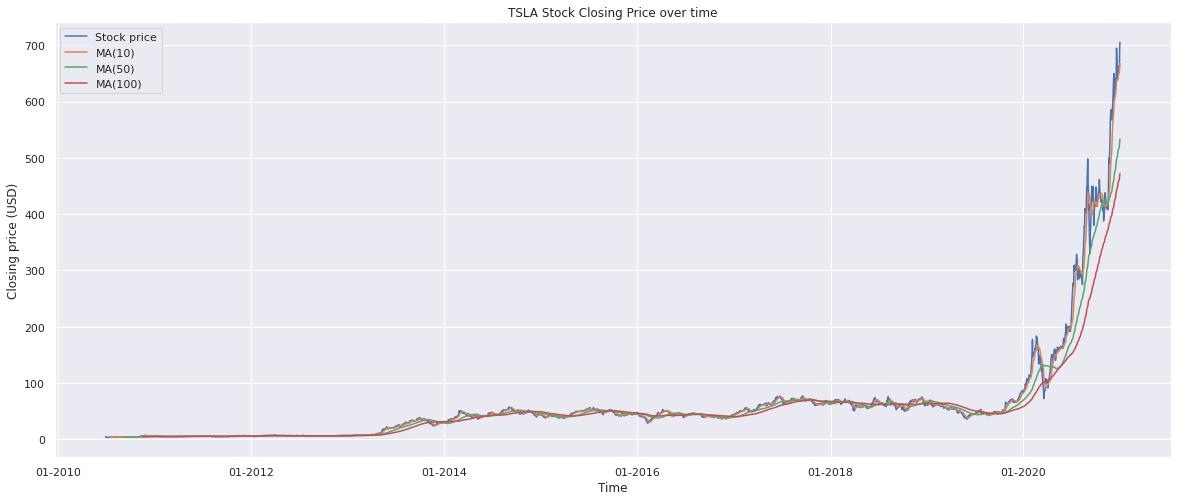

In [7]:
import datetime
import matplotlib.dates as mdates

N_YEARS = 50
values = df.tail(365*N_YEARS)[price_column]

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*N_YEARS).Date]
ax = plt.gca()
ax.set(title=f"{QUOTATION} Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Preprocessing, compute some indicators

In [8]:
df['Difference'] = compute_column_difference(df, column=price_column)
df['PercentageDiff'] = compute_percentage_diff(df)

### Plot histogram differences

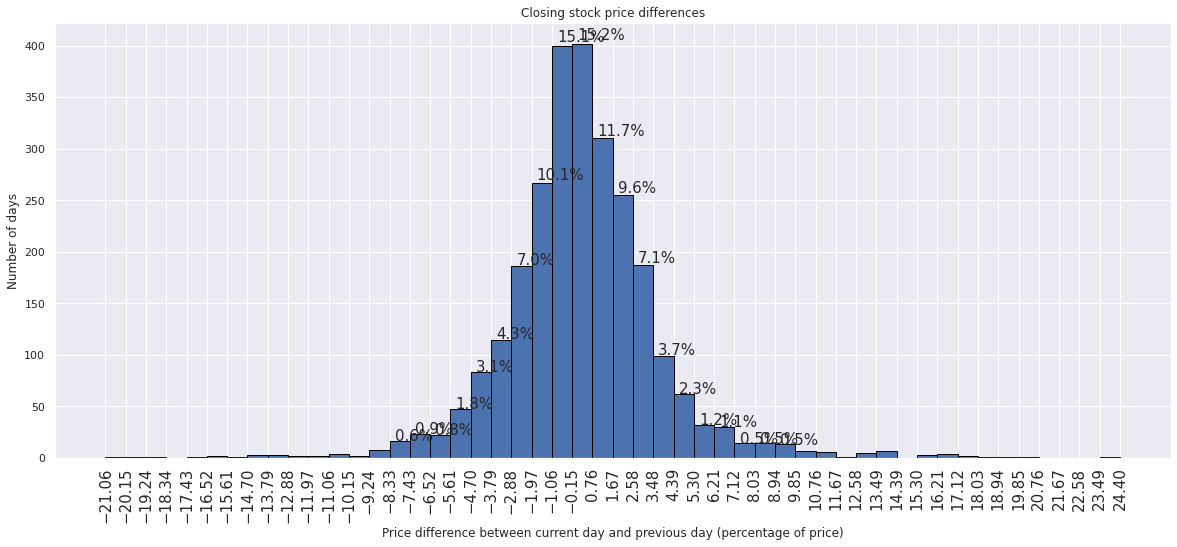

In [9]:
import matplotlib.ticker as mtick

def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)
        
values = df['PercentageDiff']
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences")
plt.xlabel('Price difference between current day and previous day (percentage of price)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

### Compute the price tendency (IE going up or down since yesterday)

In [10]:
df['Tendency'] = compute_tendency_percentage(df, diff_column='Difference', labels=['lower','higher'])
value_counts = df.Tendency.value_counts().to_dict()

for value, count in value_counts.items():
    print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
    
df.head(50)

[higher] : 1366 (51.6%)
[lower] : 1280 (48.4%)


,Date,Open,Close,Volume,Difference,PercentageDiff,Tendency
1,2010-06-29,3.800,4.778,93831500.0,NaN,NaN,NaN
2,2010-06-30,5.158,4.766,85935500.0,-0.012,-0.251151,lower
3,2010-07-01,5.000,4.392,41094000.0,-0.374,-7.847251,lower
4,2010-07-02,4.600,3.840,25699000.0,-0.552,-12.568306,lower
5,2010-07-06,4.000,3.222,34334500.0,-0.618,-16.093750,lower
6,2010-07-07,3.280,3.160,34608500.0,-0.062,-1.924271,lower
7,2010-07-08,3.228,3.492,38557000.0,0.332,10.506329,higher
8,2010-07-09,3.516,3.480,20253000.0,-0.012,-0.343643,lower
9,2010-07-12,3.590,3.410,11012500.0,-0.070,-2.011494,lower
10,2010-07-13,3.478,3.628,13400500.0,0.218,6.392962,higher


### Add the rolling average

In [11]:
N=10

ma_name = f"MA({N})"

df[ma_name] = df[price_column].rolling(N).mean()

print(df.head(15))

          Date   Open  Close      Volume  Difference  PercentageDiff Tendency  \
1   2010-06-29  3.800  4.778  93831500.0         NaN             NaN      NaN   
2   2010-06-30  5.158  4.766  85935500.0      -0.012       -0.251151    lower   
3   2010-07-01  5.000  4.392  41094000.0      -0.374       -7.847251    lower   
4   2010-07-02  4.600  3.840  25699000.0      -0.552      -12.568306    lower   
5   2010-07-06  4.000  3.222  34334500.0      -0.618      -16.093750    lower   
6   2010-07-07  3.280  3.160  34608500.0      -0.062       -1.924271    lower   
7   2010-07-08  3.228  3.492  38557000.0       0.332       10.506329   higher   
8   2010-07-09  3.516  3.480  20253000.0      -0.012       -0.343643    lower   
9   2010-07-12  3.590  3.410  11012500.0      -0.070       -2.011494    lower   
10  2010-07-13  3.478  3.628  13400500.0       0.218        6.392962   higher   
11  2010-07-14  3.588  3.968  20976000.0       0.340        9.371555   higher   
12  2010-07-15  3.988  3.978

### Add rolling average difference 

In [12]:
N_a = 20
N_b = 10

df[f"MA_diff"] = df[price_column].rolling(N_a).mean() - df[price_column].rolling(N_b).mean()

### Add the RSI

<AxesSubplot:>

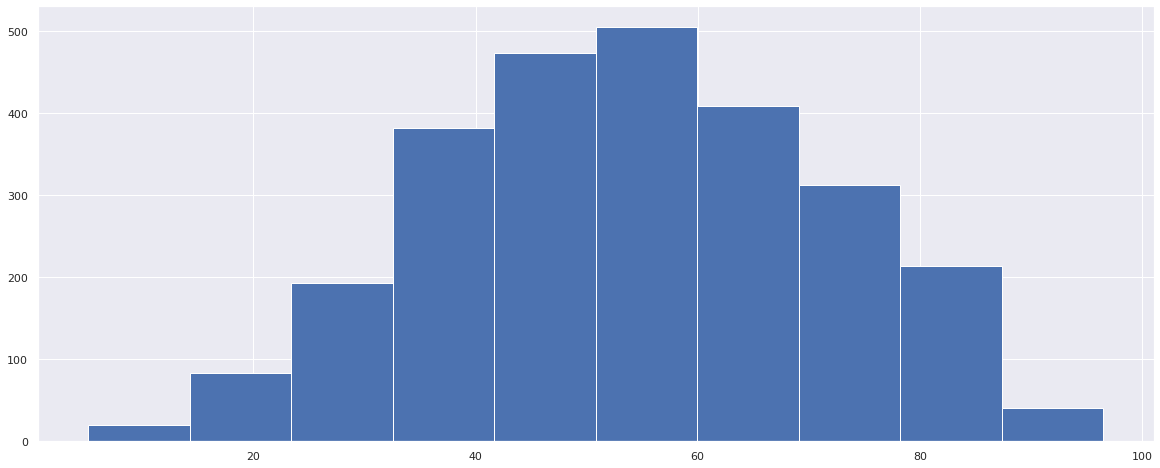

In [13]:
N = 14
rsi_name = f"RSI({N})"
df[rsi_name] = compute_RSI(df, 14, price_column=price_column, diff_column='Difference')
df[f"RSI_diff"] = compute_column_difference(df, column=rsi_name)

df[rsi_name].hist()

### Volume difference 

In [53]:
df['Volume_diff'] = compute_column_difference(df, column='Volume')

### Find the differences and tendencies for the next N days

In [68]:
N_PERIODS = 5
df['Difference'] = compute_column_difference(df, column=price_column, periods_offset=N_PERIODS)
df['PercentageDiff'] = compute_percentage_diff(df)
df['Tendency'] = compute_tendency_percentage(df, diff_column='Difference', labels=['lower','higher'])

### Find the GAP

In [69]:
df['GAP'] = compute_GAP(df)

### Shift the tendencies to predict next N days

In [70]:
df['Next'] = shift_values(df, 'Tendency', periods=-N_PERIODS)
df.head()

,Date,Open,Close,Volume,Difference,PercentageDiff,Tendency,MA(10),MA_diff,RSI(14),RSI_diff,Volume_diff,GAP,Next
30,2010-08-10,3.930,3.806,6406500.0,NaN,NaN,NaN,4.0762,0.0278,42.282750,-2.869605,2343000.0,NaN,higher
31,2010-08-11,3.738,3.580,3988000.0,NaN,NaN,NaN,4.0198,0.0648,30.769231,-11.513519,-2418500.0,0.068,higher
32,2010-08-12,3.560,3.520,3455000.0,NaN,NaN,NaN,3.9648,0.0969,27.137546,-3.631684,-533000.0,0.020,higher
33,2010-08-13,3.636,3.664,3170000.0,NaN,NaN,NaN,3.9324,0.1061,34.437870,7.300323,-285000.0,-0.116,higher
34,2010-08-16,3.690,3.756,2429000.0,NaN,NaN,NaN,3.8896,0.1176,39.600470,5.162600,-741000.0,-0.026,higher


### Remove nulls introduced by previous operations

In [71]:
df = df.dropna()

### ML Data preparation

In [72]:
df.head()

,Date,Open,Close,Volume,Difference,PercentageDiff,Tendency,MA(10),MA_diff,RSI(14),RSI_diff,Volume_diff,GAP,Next
35,2010-08-17,3.792,3.830,2239500.0,0.024,0.630583,higher,3.8336,0.1621,40.987371,1.386901e+00,-189500.0,-0.036,higher
36,2010-08-18,3.918,3.754,3006500.0,0.174,4.860335,higher,3.7838,0.1974,40.940367,-4.700387e-02,767000.0,-0.088,higher
37,2010-08-19,3.708,3.758,2895500.0,0.238,6.761364,higher,3.7506,0.2085,43.097239,2.156872e+00,-111000.0,0.046,higher
38,2010-08-20,3.730,3.820,1480000.0,0.156,4.257642,higher,3.7408,0.1964,38.120104,-4.977134e+00,-1415500.0,0.028,higher
39,2010-08-23,3.818,4.026,5440500.0,0.270,7.188498,higher,3.7514,0.1776,38.120104,2.842171e-14,3960500.0,0.002,lower


In [73]:
data_columns = ['Close', 'PercentageDiff', 'Volume_diff', 'GAP', rsi_name, 'RSI_diff', 'Next', 'Volume','MA_diff', ma_name]

dataset = df.copy()

dataset = df.loc[:, data_columns]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])

dataset.head()

,Close,PercentageDiff,Volume_diff,GAP,RSI(14),RSI_diff,Next,Volume,MA_diff,MA(10)
35,3.830,0.630583,-189500.0,-0.036,40.987371,1.386901e+00,higher,2239500.0,0.1621,3.8336
36,3.754,4.860335,767000.0,-0.088,40.940367,-4.700387e-02,higher,3006500.0,0.1974,3.7838
37,3.758,6.761364,-111000.0,0.046,43.097239,2.156872e+00,higher,2895500.0,0.2085,3.7506
38,3.820,4.257642,-1415500.0,0.028,38.120104,-4.977134e+00,higher,1480000.0,0.1964,3.7408
39,4.026,7.188498,3960500.0,0.002,38.120104,2.842171e-14,lower,5440500.0,0.1776,3.7514


### Dataset class balance

<AxesSubplot:>

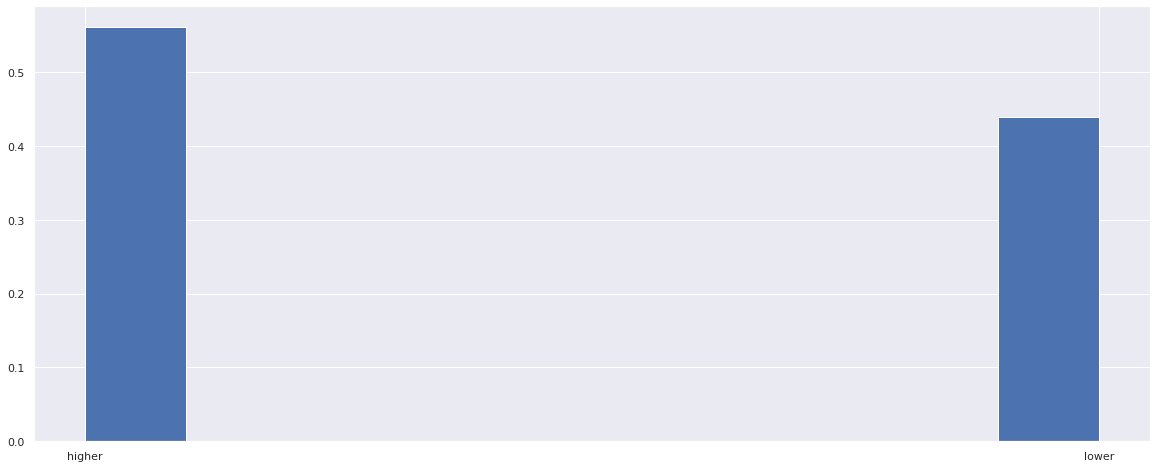

In [74]:
# plot normalized histogram
dataset['Next'].hist(weights = np.ones_like(dataset.Next) / len(dataset.Next))

### Train / Test data 

In [75]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [76]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 1815, test size : 778 (30%)


## Classifier and evaluation

In [77]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

{'higher': 0.89106529209622, 'lower': 1.1392794376098418}


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['higher' 'lower'], y=35      higher
36      higher
37      higher
38      higher
39       lower
         ...  
2623    higher
2624    higher
2625    higher
2626    higher
2627    higher
Name: Next, Length: 2593, dtype: category
Categories (2, object): ['lower' < 'higher'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}, 
               'RandomForest':{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200},
               'SVM': {'gamma': 'auto'}, 'LR': {'penalty': 'l2', 'C': 1.0}
              }

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [94]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


RF train acc : 0.94
[DTree] Accuracy : 0.49, F1 : 0.56
[RandomForest] Accuracy : 0.64, F1 : 0.64
[SVM] Accuracy : 0.56, F1 : 0.72
[LR] Accuracy : 0.56, F1 : 0.67


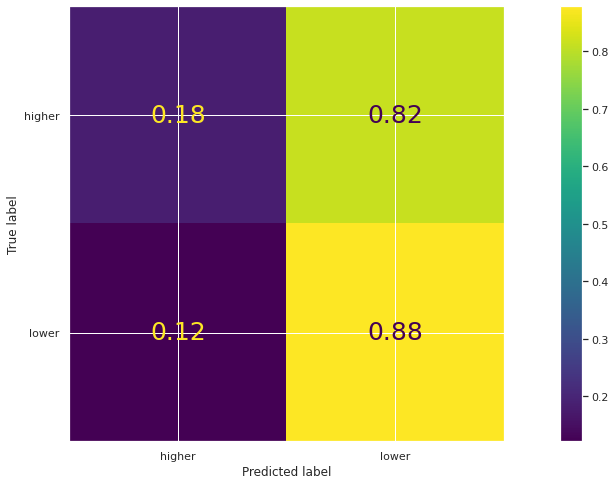

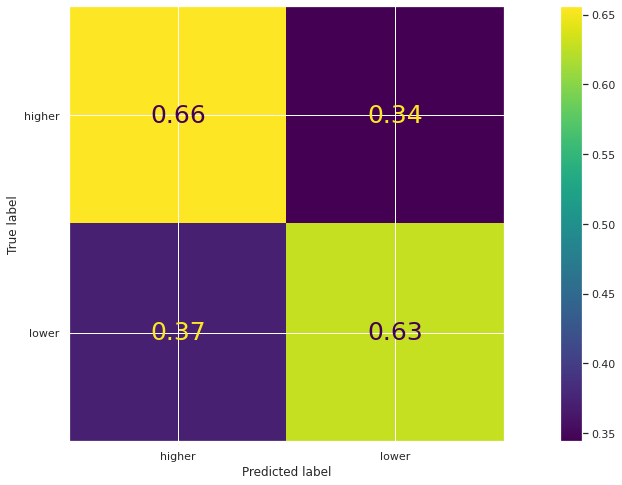

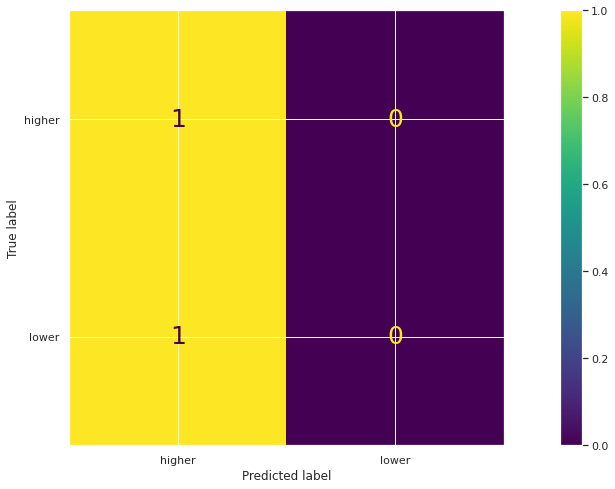

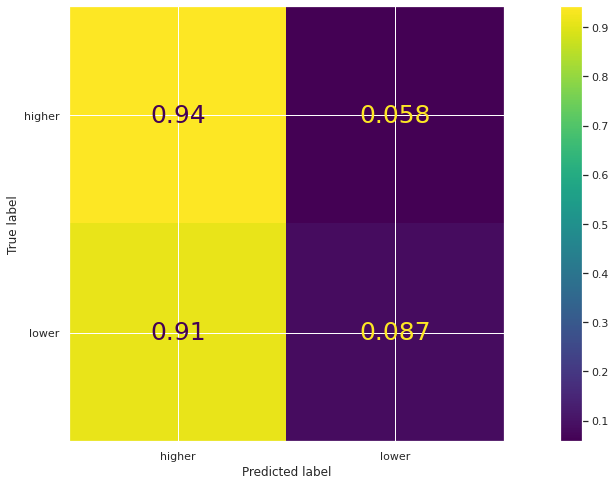

In [95]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

Y_train_pred = clf_dict['RandomForest'].predict(X_train)
train_acc = accuracy_score(Y_train, Y_train_pred)
print(f"RF train acc : {train_acc:.2f}")

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

|--- Close <= 4.02
|   |--- class: higher
|--- Close >  4.02
|   |--- Volume <= 38016000.00
|   |   |--- RSI(14) <= 16.07
|   |   |   |--- class: higher
|   |   |--- RSI(14) >  16.07
|   |   |   |--- Volume_diff <= 12871250.00
|   |   |   |   |--- MA(10) <= 87.15
|   |   |   |   |   |--- class: lower
|   |   |   |   |--- MA(10) >  87.15
|   |   |   |   |   |--- class: higher
|   |   |   |--- Volume_diff >  12871250.00
|   |   |   |   |--- RSI_diff <= 6.43
|   |   |   |   |   |--- class: lower
|   |   |   |   |--- RSI_diff >  6.43
|   |   |   |   |   |--- class: lower
|   |--- Volume >  38016000.00
|   |   |--- MA_diff <= -48.36
|   |   |   |--- class: lower
|   |   |--- MA_diff >  -48.36
|   |   |   |--- RSI(14) <= 61.00
|   |   |   |   |--- MA(10) <= 29.47
|   |   |   |   |   |--- class: higher
|   |   |   |   |--- MA(10) >  29.47
|   |   |   |   |   |--- class: lower
|   |   |   |--- RSI(14) >  61.00
|   |   |   |   |--- MA_diff <= -1.25
|   |   |   |   |   |--- class: higher
|   |  

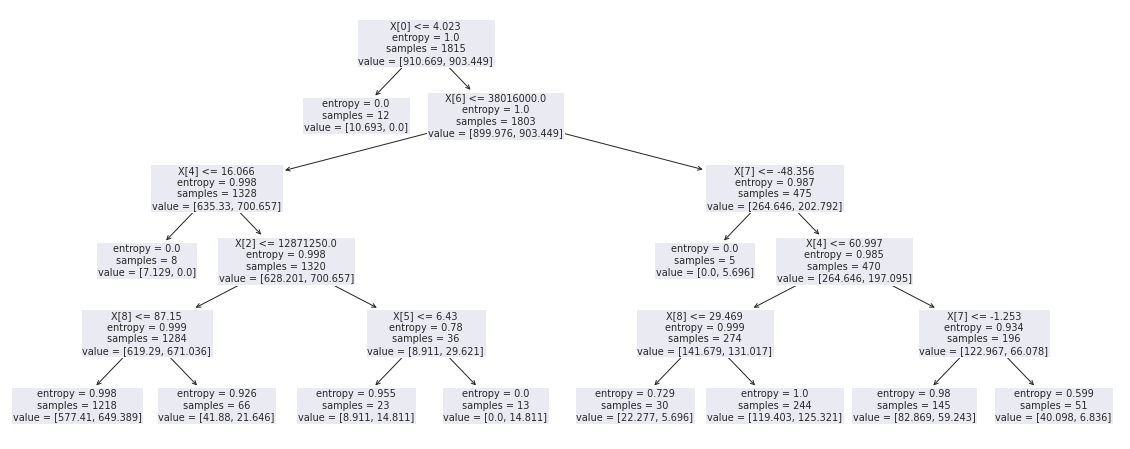

In [96]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)

In [88]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std


data_columns = ['Volume', 'Volume_diff', 'PercentageDiff', 'Next']
dataset = df.copy()
dataset = df.loc[:, data_columns]
print(dataset.head())
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']


model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

       Volume  Volume_diff  PercentageDiff    Next
35  2239500.0    -189500.0        0.630583  higher
36  3006500.0     767000.0        4.860335  higher
37  2895500.0    -111000.0        6.761364  higher
38  1480000.0   -1415500.0        4.257642  higher
39  5440500.0    3960500.0        7.188498   lower
Accuracy: 0.517 (0.032)


In [31]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)

print(X.shape)
print(selected.shape)

(2623, 3)
(2623, 3)
